In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm
from scipy import interpolate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

from keras import backend as K
from tensorflow.keras import layers

In [2]:
rf_list = sorted(glob("competition_data/rf_data/*.csv"))
rf_list

['competition_data/rf_data\\rf_2012.csv',
 'competition_data/rf_data\\rf_2013.csv',
 'competition_data/rf_data\\rf_2014.csv',
 'competition_data/rf_data\\rf_2015.csv',
 'competition_data/rf_data\\rf_2016.csv',
 'competition_data/rf_data\\rf_2017.csv',
 'competition_data/rf_data\\rf_2018.csv',
 'competition_data/rf_data\\rf_2019.csv',
 'competition_data/rf_data\\rf_2020.csv',
 'competition_data/rf_data\\rf_2021.csv',
 'competition_data/rf_data\\rf_2022.csv']

In [3]:
w_list = sorted(glob("competition_data/water_data/*.csv"))
w_list

['competition_data/water_data\\data_2012.csv',
 'competition_data/water_data\\data_2013.csv',
 'competition_data/water_data\\data_2014.csv',
 'competition_data/water_data\\data_2015.csv',
 'competition_data/water_data\\data_2016.csv',
 'competition_data/water_data\\data_2017.csv',
 'competition_data/water_data\\data_2018.csv',
 'competition_data/water_data\\data_2019.csv',
 'competition_data/water_data\\data_2020.csv',
 'competition_data/water_data\\data_2021.csv',
 'competition_data/water_data\\data_2022.csv']

In [4]:
#전체 데이터 병합후 저장

for i in range(len(rf_list)):
    pd.concat([pd.read_csv(rf_list[i], index_col = 0),pd.read_csv(w_list[i], index_col = 0)], axis=1).to_csv('competition_data/full_data/f_list_'+str(i).zfill(2)+'.csv')

In [5]:
# 병합데이터 불러오기

f_list = sorted(glob("competition_data/full_data/*.csv")) #
f_list

['competition_data/full_data\\f_list_00.csv',
 'competition_data/full_data\\f_list_01.csv',
 'competition_data/full_data\\f_list_02.csv',
 'competition_data/full_data\\f_list_03.csv',
 'competition_data/full_data\\f_list_04.csv',
 'competition_data/full_data\\f_list_05.csv',
 'competition_data/full_data\\f_list_06.csv',
 'competition_data/full_data\\f_list_07.csv',
 'competition_data/full_data\\f_list_08.csv',
 'competition_data/full_data\\f_list_09.csv',
 'competition_data/full_data\\f_list_10.csv']

In [6]:
pd.read_csv(f_list[0]).shape

(26496, 18)

In [7]:
pd.read_csv(f_list[0])

,ymdhm,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630
0,2012-05-01 00:00,0.0,0.0,0.0,24.800,555.0,219.07,24.93,555.0,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,0.0,0.0,0.0,24.794,464.6,218.86,25.15,562.9,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,0.0,0.0,0.0,24.789,478.1,218.69,25.31,576.4,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,0.0,0.0,0.0,24.789,464.8,218.69,25.31,563.1,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,0.0,0.0,0.0,24.789,478.1,218.69,25.31,576.4,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2012-10-31 23:10,0.0,0.0,0.0,25.250,270.2,235.01,8.99,270.2,300.0,372.7,1018.67,364.2,0.0,365.0,1395.30,351.3,1837.11
26492,2012-10-31 23:20,0.0,0.0,0.0,25.250,264.1,235.01,8.99,264.1,286.0,365.7,945.75,359.2,0.0,362.0,1154.21,350.3,1814.92
26493,2012-10-31 23:30,0.0,0.0,0.0,25.250,257.9,235.01,8.99,257.9,273.0,362.7,915.35,356.2,0.0,359.0,968.58,349.3,1792.88
26494,2012-10-31 23:40,0.0,0.0,0.0,25.250,264.1,235.01,8.99,264.1,261.0,355.7,846.39,352.2,0.0,356.0,776.99,346.3,1727.56


In [8]:
#window_size 200으로 묶어 train dataset 만들기

train_data = []
train_label = []
num = 0

window = 30

for i in f_list[:-1]:
    
    tmp = pd.read_csv(i)
    
    # 10분전, 20분전 데이터와의 차이값을 추가 변수로 활용
    
    tmp[["wl_1018662_1", "wl_1018680_1", "wl_1018683_1", "wl_1019630_1"]] = tmp[["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]].reset_index(drop=True) - pd.concat([tmp[:1][["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]],
                                                                                                             tmp[:-1][["wl_1018662", "wl_1018680","wl_1018683","wl_1019630"]]], axis = 0).reset_index(drop=True)
    tmp[["wl_1018662_2", "wl_1018680_2", "wl_1018683_2", "wl_1019630_2"]] = tmp[["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]].reset_index(drop=True) - pd.concat([tmp[:2][["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]],
                                                                                                             tmp[:-2][["wl_1018662", "wl_1018680","wl_1018683","wl_1019630"]]], axis = 0).reset_index(drop=True)

    tmp = tmp.replace(" ", np.nan)
    tmp = tmp.interpolate(method = 'values')
    tmp = tmp.fillna(0)

    for j in tqdm(range(len(tmp)-window)):
        train_data.append(np.array(tmp.loc[j:j + window-1,
                                           ['rf_10184100','rf_10184110','rf_10184140',"swl", "inf", "sfw", "ecpc",
                                            "tototf", "tide_level","fw_1018662", "fw_1018680","fw_1018683", "fw_1019630",
                                            "wl_1018662", "wl_1018680", "wl_1018683","wl_1019630",
                                            "wl_1018662_1", "wl_1018680_1", "wl_1018683_1", "wl_1019630_1",
                                           "wl_1018662_2", "wl_1018680_2", "wl_1018683_2", "wl_1019630_2"]]).astype(float))
        
        train_label.append(np.array(tmp.loc[j + window, ["wl_1018662", "wl_1018680",
                                                      "wl_1018683", "wl_1019630"]]).astype(float))

100%|███████████████████████████████████████████████████████████████████████████| 26466/26466 [00:34<00:00, 758.84it/s]


In [9]:
# Train dataset을 계속 사용할 수 있도록 저장

train_data = np.array(train_data)
train_label = np.array(train_label)

print(train_data.shape)
print(train_label.shape)

np.save("train_data2.npy",train_data)
np.save("train_label2.npy",train_label)

(264660, 30, 25)
(264660, 4)


In [10]:
# Train dataset 불러오기

train_data = np.load("train_data2.npy")
train_label = np.load("train_label2.npy")

In [11]:
#metric 및 loss함수로 사용할 함수 지정

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def score(y_test, y_pred):
    return rmse(y_test, y_pred) / r2(y_test, y_pred)

In [12]:
input_shape = (train_data[0].shape[0], train_data[0].shape[1])

model = Sequential()
#model.add(GRU(256, input_shape=input_shape))
#model.add(GRU(32, return_sequences=False))
#model.add(Dense(4, activation = 'relu'))

model.add(layers.Conv1D(256, (3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(512, (3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(64, (3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D((2)))
model.add(layers.Flatten())
model.add(Dense(4, activation = 'relu'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                     beta_1=0.9,
                                     beta_2=0.999,
                                     epsilon=1e-07)

model.compile(optimizer=optimizer,loss = rmse, metrics=[score,'mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 256)           19456     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 512)           393728    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 512)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 64)             98368     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 64)            0

In [13]:
model.fit(train_data, train_label, epochs=100, batch_size=1024) 
# batch_size는 512를 사용하여도 생각외로 높은 성능을 보임
# 시간이 많다면 epoch를 크게 높이는 것도 방법...

Epoch 1/100
259/259 [==============================] - 53s 199ms/step - loss: 162.7962 - score: -30.8571 - mae: 91.7024
Epoch 2/100
259/259 [==============================] - 54s 208ms/step - loss: 102.1734 - score: -9.7092 - mae: 56.0070
Epoch 3/100
259/259 [==============================] - 54s 208ms/step - loss: 6.5336 - score: 6.6504 - mae: 5.6663
Epoch 4/100
259/259 [==============================] - 56s 215ms/step - loss: 5.3844 - score: 5.4454 - mae: 4.6403
Epoch 5/100
259/259 [==============================] - 55s 213ms/step - loss: 4.7166 - score: 4.7544 - mae: 4.0454
Epoch 6/100
259/259 [==============================] - 55s 213ms/step - loss: 4.3593 - score: 4.3895 - mae: 3.7412
Epoch 7/100
259/259 [==============================] - 55s 213ms/step - loss: 4.1622 - score: 4.1880 - mae: 3.5769
Epoch 8/100
259/259 [==============================] - 55s 213ms/step - loss: 3.9535 - score: 3.9755 - mae: 3.4018
Epoch 9/100
259/259 [==============================] - 55s 213ms/step -

In [16]:
# 검증용 데이터 만들기
test_data = []

tmp = pd.read_csv(f_list[-1])
tmp = tmp.replace(" ", np.nan)

# 이전값을 사용
tmp = tmp.fillna(method = 'pad')
tmp = tmp.fillna(0)
tmp.index = tmp.ymdhm

tmp['wl_1018662'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1018662']
tmp['wl_1018680'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1018680']
tmp['wl_1018683'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1018683']
tmp['wl_1019630'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1019630']

tmp = tmp.reset_index(drop=True)

tmp[["wl_1018662_1", "wl_1018680_1", "wl_1018683_1", "wl_1019630_1"]] = tmp[["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]] - pd.concat([tmp[:1][["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]], tmp[:-1][["wl_1018662", "wl_1018680","wl_1018683","wl_1019630"]]], axis = 0).reset_index(drop=True)  
tmp[["wl_1018662_2", "wl_1018680_2", "wl_1018683_2", "wl_1019630_2"]] = tmp[["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]] - pd.concat([tmp[:2][["wl_1018662", "wl_1018680", "wl_1018683","wl_1019630"]], tmp[:-2][["wl_1018662", "wl_1018680","wl_1018683","wl_1019630"]]], axis = 0).reset_index(drop=True)

tmp

C:\Users\82107\AppData\Local\Temp\ipykernel_25644\1362110938.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['wl_1018662'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1018662']
C:\Users\82107\AppData\Local\Temp\ipykernel_25644\1362110938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['wl_1018680'].iloc[-6912:] = pd.read_csv("정답.csv", index_col = 'ymdhm')['wl_1018680']
C:\Users\82107\AppData\Local\Temp\ipykernel_25644\1362110938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,ymdhm,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,...,wl_1019630,fw_1019630,wl_1018662_1,wl_1018680_1,wl_1018683_1,wl_1019630_1,wl_1018662_2,wl_1018680_2,wl_1018683_2,wl_1019630_2
0,2022-05-01 00:00,0.0,0.0,0.0,25.20,739.36,218.73,25.27,124.36,81.0,...,269.30000,471.08,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2022-05-01 00:10,0.0,0.0,0.0,25.20,124.48,218.73,25.27,124.48,72.0,...,266.30000,438.33,1.00000,0.00000,0.00000,-3.00000,0.00000,0.00000,0.00000,0.00000
2,2022-05-01 00:20,0.0,0.0,0.0,25.20,124.20,218.73,25.27,124.20,64.0,...,264.30000,417.17,-1.00000,0.00000,0.00000,-2.00000,0.00000,0.00000,0.00000,-5.00000
3,2022-05-01 00:30,0.0,0.0,0.0,25.20,124.35,218.73,25.27,124.35,58.0,...,263.30000,406.79,-1.00000,0.00000,0.00000,-1.00000,-2.00000,0.00000,0.00000,-3.00000
4,2022-05-01 00:40,0.0,0.0,0.0,25.19,0.00,218.36,25.64,124.42,58.0,...,264.30000,417.17,-2.00000,0.00000,0.00000,1.00000,-3.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,2022-07-18 23:10,0.0,0.0,0.0,25.04,259.23,212.86,31.14,259.23,510.0,...,315.28455,974.40,5.35227,4.53464,6.21457,0.69587,7.32880,4.71057,7.40488,7.29508
11372,2022-07-18 23:20,0.0,0.0,0.0,25.04,260.46,212.86,31.14,260.46,492.0,...,320.03653,1006.88,3.33355,-0.65332,6.32382,4.75198,8.68582,3.88132,12.53839,5.44785
11373,2022-07-18 23:30,0.0,0.0,0.0,25.04,259.37,212.86,31.14,259.37,475.0,...,324.38820,1039.90,5.29462,9.94428,9.28342,4.35167,8.62817,9.29096,15.60724,9.10365
11374,2022-07-18 23:40,0.0,0.0,0.0,25.04,259.13,212.86,31.14,259.13,458.0,...,317.68607,1073.46,11.73724,7.36996,-0.85373,-6.70213,17.03186,17.31424,8.42969,-2.35046


In [17]:
for j in tqdm(range(len(tmp)-window)): 
    test_data.append(np.array(tmp.loc[j:j + window-1,
                                      ['rf_10184100','rf_10184110','rf_10184140',"swl", "inf", "sfw", "ecpc",
                                       "tototf", "tide_level","fw_1018662", "fw_1018680","fw_1018683", "fw_1019630",
                                       "wl_1018662", "wl_1018680", "wl_1018683","wl_1019630",
                                       "wl_1018662_1", "wl_1018680_1", "wl_1018683_1", "wl_1019630_1",
                                       "wl_1018662_2", "wl_1018680_2", "wl_1018683_2", "wl_1019630_2"]]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████| 11346/11346 [00:11<00:00, 1006.82it/s]


In [18]:
test_data = np.array(test_data)

print(test_data.shape)
print(test_data[0].shape)

(11346, 30, 25)
(30, 25)


In [21]:
#제출 파일 만들기

pred = model.predict(test_data[-6912:])
pred = pd.DataFrame(pred)

sample_submission = pd.read_csv("competition_data/sample_submission.csv")

sample_submission["wl_1018662"] = pred[0]
sample_submission["wl_1018680"] = pred[1]
sample_submission["wl_1018683"] = pred[2]
sample_submission["wl_1019630"] = pred[3]

sample_submission.to_csv("baseline_CNN.csv", index = False)

216/216 [==============================] - 2s 7ms/step


In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

In [7]:
df = pd.read_csv("정답.csv", encoding='cp949')
df

,ymdhm,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,2022-06-01 00:00,284.82303,276.26846,276.51430,276.57425
1,2022-06-01 00:10,285.56018,276.75750,276.49020,275.76968
2,2022-06-01 00:20,287.73310,277.94965,276.31668,272.15955
3,2022-06-01 00:30,289.02252,277.81060,279.31296,268.32570
4,2022-06-01 00:40,290.17212,278.62550,274.60342,266.82800
...,...,...,...,...,...
6907,2022-07-18 23:10,297.75327,294.12234,300.67813,315.28455
6908,2022-07-18 23:20,301.08682,293.46902,307.00195,320.03653
6909,2022-07-18 23:30,306.38144,303.41330,316.28537,324.38820
6910,2022-07-18 23:40,318.11868,310.78326,315.43164,317.68607


In [8]:
df1 = pd.read_csv("baseline_CNN.csv", encoding='cp949')
df1

,ymdhm,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,2022-06-01 00:00,278.32043,274.98373,273.84000,268.44287
1,2022-06-01 00:10,280.50296,275.94452,274.84528,267.67767
2,2022-06-01 00:20,284.55542,276.85260,275.16730,265.16806
3,2022-06-01 00:30,288.45877,277.37850,274.68637,261.56012
4,2022-06-01 00:40,292.16632,281.11035,277.13920,261.74423
...,...,...,...,...,...
6907,2022-07-18 23:10,299.63287,296.77590,297.63406,318.91107
6908,2022-07-18 23:20,301.94867,301.32025,301.48267,323.27658
6909,2022-07-18 23:30,309.46200,300.60828,308.96094,322.29090
6910,2022-07-18 23:40,313.96573,311.31357,315.03265,324.41095


In [21]:
df.columns = ['ymdhm','청담대교 수위','잠수교 수위','한강대교 수위','행주대교 수위']
df1.columns = ['ymdhm','청담대교 수위','잠수교 수위','한강대교 수위','행주대교 수위']

,ymdhm,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위
0,2022-06-01 00:00,284.82303,276.26846,276.51430,276.57425
1,2022-06-01 00:10,285.56018,276.75750,276.49020,275.76968
2,2022-06-01 00:20,287.73310,277.94965,276.31668,272.15955
3,2022-06-01 00:30,289.02252,277.81060,279.31296,268.32570
4,2022-06-01 00:40,290.17212,278.62550,274.60342,266.82800
...,...,...,...,...,...
6907,2022-07-18 23:10,297.75327,294.12234,300.67813,315.28455
6908,2022-07-18 23:20,301.08682,293.46902,307.00195,320.03653
6909,2022-07-18 23:30,306.38144,303.41330,316.28537,324.38820
6910,2022-07-18 23:40,318.11868,310.78326,315.43164,317.68607


<Figure size 1008x288 with 0 Axes>

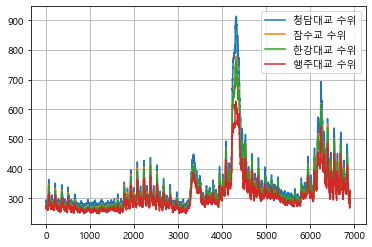

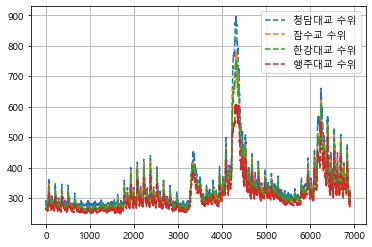

In [23]:
# 예측 결과 시각화
plt.figure(figsize=(14,4))
df.plot(label='Origin')
plt.grid()
df1.plot(label='Prediction', linestyle='--')
plt.legend()
plt.grid()

<Figure size 1008x360 with 0 Axes>

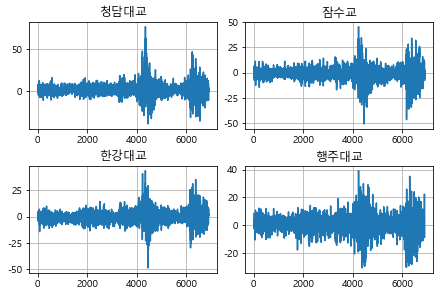

In [48]:
# 예측 오차
plt.figure(figsize=(14,5))
df['Err1'] = df['청담대교 수위'] - df1['청담대교 수위']
df['Err2'] = df['잠수교 수위'] - df1['잠수교 수위']
df['Err3'] = df['한강대교 수위'] - df1['한강대교 수위']
df['Err4'] = df['행주대교 수위'] - df1['행주대교 수위']
plt.subplots(constrained_layout=True)

plt.subplot(221)
plt.title('청담대교')
df['Err1'].plot()
plt.grid()

plt.subplot(222)
plt.title('잠수교')
df['Err2'].plot()
plt.grid()

plt.subplot(2,2,3)
plt.title('한강대교')
df['Err3'].plot()
plt.grid()

plt.subplot(2,2,4)
plt.title('행주대교')
df['Err4'].plot()
plt.grid()

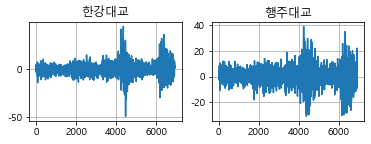

In [43]:
plt.subplot(2,2,3)
plt.title('한강대교')
df['Err3'].plot()
plt.grid()

plt.subplot(2,2,4)
plt.title('행주대교')
df['Err4'].plot()
plt.grid()

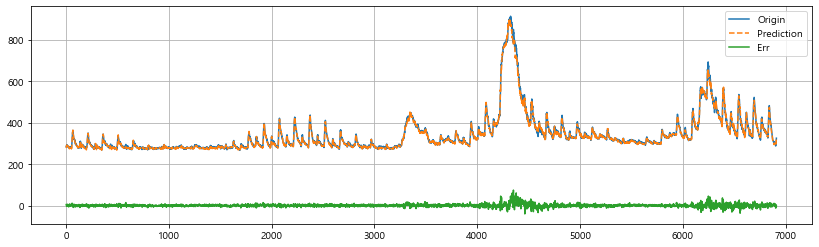

In [31]:
#청담대교 수위
plt.figure(figsize=(14,4))
df['청담대교 수위'].plot(label='Origin')
df1['청담대교 수위'].plot(label='Prediction', linestyle='--')
df['Err'] = df['청담대교 수위'] - df1['청담대교 수위']
df['Err'].plot()
plt.legend()
plt.grid()

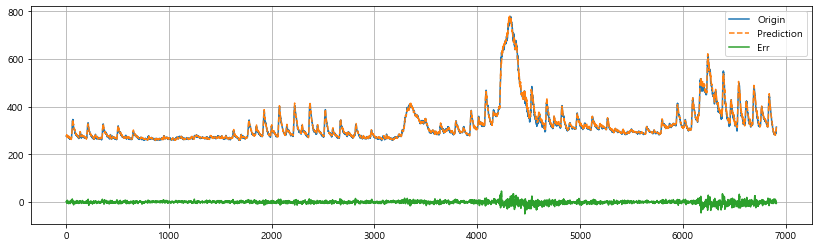

In [28]:
#잠수교 수위
plt.figure(figsize=(14,4))
df['잠수교 수위'].plot(label='Origin')
df1['잠수교 수위'].plot(label='Prediction', linestyle='--')
df['Err'] = df['잠수교 수위'] - df1['잠수교 수위']
df['Err'].plot()
plt.legend()
plt.grid()

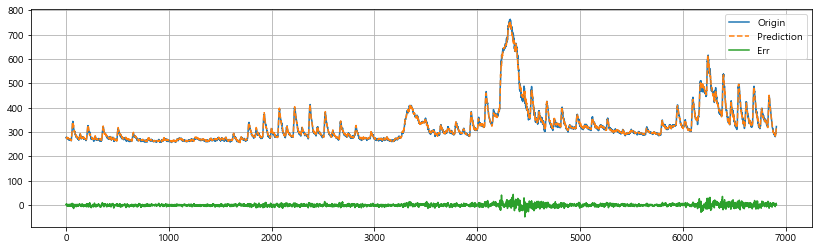

In [29]:
#한강대교 수위
plt.figure(figsize=(14,4))
df['한강대교 수위'].plot(label='Origin')
df1['한강대교 수위'].plot(label='Prediction', linestyle='--')
df['Err'] = df['한강대교 수위'] - df1['한강대교 수위']
df['Err'].plot()
plt.legend()
plt.grid()

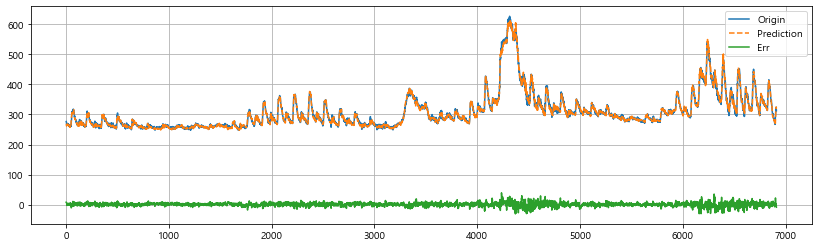

In [30]:
#행주대교 수위
plt.figure(figsize=(14,4))
df['행주대교 수위'].plot(label='Origin')
df1['행주대교 수위'].plot(label='Prediction', linestyle='--')
df['Err'] = df['행주대교 수위'] - df1['행주대교 수위']
df['Err'].plot()
plt.legend()
plt.grid()